# Build and Zip PNG Files - Hackathon

In this notebook, we'll take the `basic` data set, use `ibmseti` Python package to convert each data file into a spectrogram, then save as `.png` files.


Then, we'll split the data set into a training set and a test set and create a handful of zip files for each class. This will dovetail into the next tutorial where we will train a custom Watson Visual Recognition classifier (we will use the zip files of pngs) and measure it's performance with the test s

## Spark Enterprise Cluster

This notebook is currently written to run on the Spark Enterprise Cluster. That is, the variables point to the data locations on the Enterprise Cluster. 

#### PowerAI

However, if you wish to run this on the PowerAI systems at the Hackathon, read cell 3 below. You only need to uncomment a few lines so that variables point to the data locations on the PowerAI system.

In [1]:
from __future__ import division

import cStringIO
import glob
import json
import requests
import ibmseti
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
%matplotlib inline
import matplotlib.image as mpimg
import scipy
from scipy import stats
from mpl_toolkits.mplot3d import axes3d

ImportError: 
Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
If you're working with a numpy git repo, try `git clean -xdf` (removes all
files not under version control).  Otherwise reinstall numpy.

Original error was: /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages/numpy/core/multiarray.so: undefined symbol: PyUnicodeUCS2_AsUTF8String


In [5]:
### SET YOUR TEAM NAME HERE! Use this folder to save intermediate results
teamname = 'benders'

mydatafolder = os.path.join( os.environ['PWD'], teamname )      

# Create folder for zip to extract to
setiDataDir = mydatafolder + '/data'
if os.path.exists(setiDataDir) is False:
    os.makedirs(setiDataDir)
    
# Create folder for future spectrograms
outputpng_folder = mydatafolder + '/png'
if os.path.exists(outputpng_folder) is False:
    os.makedirs(outputpng_folder)

In [6]:
# Extract Data folder
def unzip_data(dest, zipf):
    # zipf = array of zip files     
    for i in zipf:
        zz = zipfile.ZipFile(mydatafolder + '/' + i )
        zz.extractall(dest)
    
unzip_data(setiDataDir, ['basic4.zip'])

# when using the larger dataset, you will have multiple zip files. Pass an array of those zip files to unzip_data

In [7]:
# Choose your data set!
workingDataDir = setiDataDir
workingIndexFile = os.path.join( mydatafolder + '/public_list_basic_v2_26may_2017.csv' )

In [8]:
#Use `ibmseti`, or other methods, to draw the spectrograms

def draw_spectrogram(data):
    
    aca = ibmseti.compamp.SimCompamp(data)
    spec = aca.get_spectrogram()
    
    
    # Instead of using SimCompAmp.get_spectrogram method
    # perform your own signal processing here before you create the spectrogram
    #
    # SimCompAmp.get_spectrogram is relatively simple. Here's the code to reproduce it:
    #
    # header, raw_data = r.content.split('\n',1)
    # complex_data = np.frombuffer(raw_data, dtype='i1').astype(np.float32).view(np.complex64)
    # complex_data = complex_data - complex_data.mean()  # have to subtract off any DC offset
    # shape = (32, 6144)
    # spec = np.abs( np.fft.fftshift( np.fft.fft( complex_data.reshape(*shape) ), 1) )**2
    # 
    # But instead of the line above, can you maniputlate `complex_data` with signal processing
    # techniques in the time-domain (windowing?, de-chirp?), or manipulate the output of the 
    # np.fft.fft process in a way to improve the signal to noise (Welch periodogram, subtract noise model)? 
    # 
    # example: Apply Hanning Window
    # complex_data = complex_data.reshape(*shape)
    # complex_data = complex_data * np.hanning(complex_data.shape[1])
    # spec = np.abs( np.fft.fftshift( np.fft.fft( complex_data ), 1) )**2

    
    ## Noise Subtraction
    #
    #  If you are building an average noise spectrogram model for subtraction, you should do that here.
    #
    #  See the Example to build an average noise spectrogram: 
    #
    #  Important point: If you do signal processing above to the raw data, you should apply the exact same signal processing
    #     when you calculate your average noise spectrogram
    #
    #    import pickle
    #    ave_noise_spec = pickle.load(os.path.join(mydatafolder, 'ave_noise_spec.pickle'))
    #    spec = spec - ave_noise_spec
    #
    #
    
    #fig, ax = plt.subplots(figsize=(10, 5))   

    # do different color mappings affect Watson's classification accuracy?
    
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0], cmap='hot')
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0], cmap='gray')
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0], cmap='Greys')
    
   ### ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0], cmap='gray')
    #MaxAmps = spec.max(axis=1)
    MaxAmps_Freq = spec.argmax(1)
    MaxAmps_Time = np.arange(31,-1,-1)
    # Fit a staright line to the spectrogram signal
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MaxAmps_Freq, MaxAmps_Time)
    maxAmp = spec.max()
    
    #plt.plot(MaxAmps_Freq, MaxAmps_Time)
    #plt.axis('off')
    #plt.xlim([0,6144])
    #plt.ylim([0,32])
    #plt.title('%s, Index: %s \n UUID: %s'%(aca.header()['signal_classification'],index,aca.header()['uuid']))

    ##
    ## For other ways to create Images, see: 
    ## tutorials/Step_5c_Convert_TS_to_unit8Dataset_DSX.ipynb
    ##
    
    #return fig, aca.header()
    return aca.header(), slope, intercept, r_value, p_value, std_err, maxAmp


def convert_to_spectrogram_and_save(row):
    
    try:
        uuid, classification = row.split(',')
    except:
        uuid = row #this handles the test data since it doesn't have "SIGNAL_CLASSIFICATION" in index file
        classification = 'unknown: test data'
        
        
    #create path to local data file
    filename = uuid + '.dat'
    filepath = os.path.join(workingDataDir, filename)
    
    #retrieve that data file
    rawdata = open(filepath).read()
    
    
    header, slope, intercept, r_value, p_value, std_err, maxAmp = draw_spectrogram(rawdata)
    #png_file_name = filename + '.png'
    #fig.savefig( os.path.join(outputpng_folder, png_file_name) )
    #plt.close(fig)
    
    #return (filename, header, png_file_name)
    return (header, slope, intercept, r_value, p_value, std_err, maxAmp)

In [9]:
rdd = sc.textFile(workingIndexFile, 30).filter(lambda x: x.startswith('UUID') is False) #the filter removes the header

In [10]:
rdd.count()

4000

In [11]:
#rdd1=rdd.take(5)
#rdd1

In [12]:
# 0-header, 1-slope, 2-intercept, 3-r_value, 4-p_value, 5-std_err, 6-maxAmp
#results = rdd.map(convert_to_spectrogram_and_save).take(5)
results = rdd.map(convert_to_spectrogram_and_save).collect()

In [13]:
print(len(results[2])) # check how many parameters are created for each spectrogram
print(len(results)) # check the total number of signals

7
4000


In [14]:
index=1300 # pick a signal to verify its parameters
print(type(results[index]))
print(results[index])

<type 'tuple'>
({u'signal_classification': u'squiggle', u'uuid': u'978b722d-487a-4cfc-add7-467acaabb7a8'}, 0.017539658799906013, -36.275428434310058, 0.92282312153216339, 5.8037001340779494e-14, 0.0013367657767248944, 94749581.356077194)


In [15]:
# 0-header, 1-slope, 2-intercept, 3-r_value, 4-p_value, 5-std_err, 6-maxAmp
Class = [results[j][0]['signal_classification'] for j in range(len(results))] # Separate parameters in separate lists
uuid = [results[j][0]['uuid'] for j in range(len(results))] # Separate parameters in separate lists
R_Val = [results[j][3] for j in range(len(results))] # Separate parameters in separate lists
P_Val = [results[j][4] for j in range(len(results))] # Separate parameters in separate lists
Max_Amp = [results[j][6] for j in range(len(results))] # Separate parameters in separate lists

In [16]:
# Separate signals based on low max-amplitude (noise)
LowAmp = [Class[i] for i in range(len(results)) if np.log10(Max_Amp[i])<7.5]
Noise_results = [uuid[i] for i in range(len(results)) if np.log10(Max_Amp[i])<7.5]
print('Guess Noise#=',len(LowAmp))
cnt=0
for i in range(len(LowAmp)): # check the number of 'noise' classified signals in the cluster classified as 'noise'
    if LowAmp[i]=='noise':
        cnt+=1
print('Actual Noise#=',cnt)

('Guess Noise#=', 989)
('Actual Noise#=', 989)


In [17]:
# Separate signals based on high p-value and high max-amplitude, meaning near perfect straight line (narrow band (NB))
# with high SNR
HighP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])<-45 and np.log10(Max_Amp[i])>7.5]
NB_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])<-45 and np.log10(Max_Amp[i])>7.5]
print('Guess NB#=',len(HighP))
cnt=0
for i in range(len(HighP)):
    if HighP[i]=='narrowband': # check the number of 'NB' classified signals in the cluster classified as 'NB'
        cnt+=1
print('Actual NB#=',cnt)

('Guess NB#=', 939)
('Actual NB#=', 939)


In [18]:
# Separate signals based on mid-range p-value and high max-amplitude, meaning curved line (dynamic drift signals (drd))
MidP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])>-45 and np.log10(P_Val[i])<-15 and np.log10(Max_Amp[i])>7.5]
drd_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])>-45 and np.log10(P_Val[i])<-15 and np.log10(Max_Amp[i])>7.5]
print('Guess drd#=',len(MidP))
cnt=0
for i in range(len(MidP)):
    if MidP[i]=='narrowbanddrd': # check the number of 'drd' classified signals in the cluster classified as 'drd'
        cnt+=1
print('Actual drd#=',cnt)

('Guess drd#=', 926)
('Actual drd#=', 829)


In [19]:
# Separate signals based on low p-value and high max-amplitude, meaning wavy line (squiggle)
LowP = [Class[i] for i in range(len(results)) if np.log10(P_Val[i])>-15 and np.log10(Max_Amp[i])>7.5]
suiggle_results = [uuid[i] for i in range(len(results)) if np.log10(P_Val[i])>-15 and np.log10(Max_Amp[i])>7.5]
print('Guess squiggle#=',len(LowP))
cnt=0
for i in range(len(LowP)):
    if LowP[i]=='squiggle': # check the number of 'squiggle' classified signals in the cluster classified as 'squiggle'
        cnt+=1
print('Actual squiggle#=',cnt)

('Guess squiggle#=', 1146)
('Actual squiggle#=', 946)


In [28]:
# Plot color as per signal type
color = [None] * len(Class)
for i in range(len(Class)):
    if Class[i] == 'noise':
        color[i] = 'black'
    elif Class[i] == 'narrowband':
        color[i] = 'blue'
    elif Class[i] == 'narrowbanddrd':
        color[i] = 'white'
    else:
        color[i] = 'red' # Squiggle

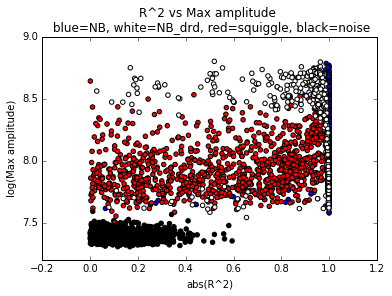

In [45]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(map(abs, R_Val), np.log10(Max_Amp),c=color)
plt.title('R^2 vs Max amplitude \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('abs(R^2)')
plt.ylabel('log(Max amplitude)')
plt.show()

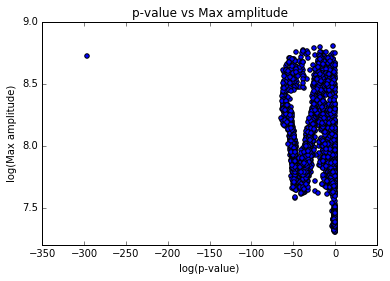

In [21]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log10(P_Val), np.log10(Max_Amp))
plt.title('p-value vs Max amplitude')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
#plt.xlim([-160,10])
plt.show()

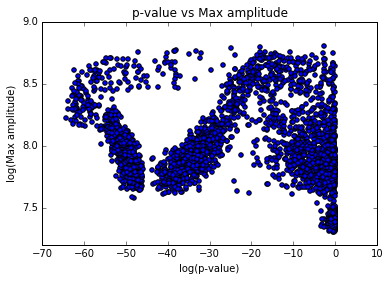

In [22]:
# Remove that one outlier
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log10(P_Val), np.log10(Max_Amp))
plt.title('p-value vs Max amplitude')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-70,10])
plt.show()

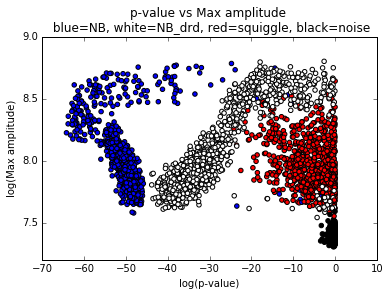

In [44]:
# Remove that one outlier and plot color as per signal type
plt.scatter(np.log10(P_Val), np.log10(Max_Amp),c=color)
plt.title('p-value vs Max amplitude \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('log(p-value)')
plt.ylabel('log(Max amplitude)')
plt.xlim([-70,10])
plt.show()

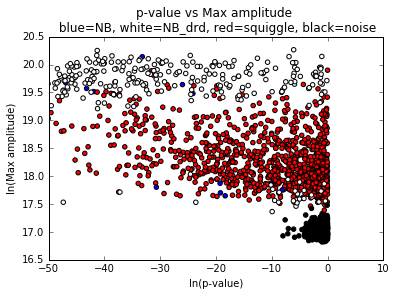

In [46]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
#plt.scatter(map(abs, R_Val), map(log, Max_Amp))
plt.scatter(np.log(P_Val), np.log(Max_Amp),c=color)
plt.title('p-value vs Max amplitude \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('ln(p-value)')
plt.ylabel('ln(Max amplitude)')
plt.xlim([-50,10])
plt.show()

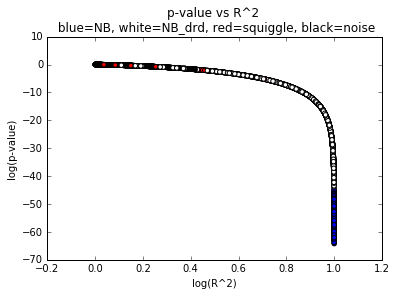

In [47]:
# Plot all data in various combinations of parameters to get a 2D plot where one can identify clusters
plt.scatter(map(abs, R_Val), np.log10(P_Val),c=color)
plt.title('p-value vs R^2 \n blue=NB, white=NB_drd, red=squiggle, black=noise')
plt.xlabel('log(R^2)')
plt.ylabel('log(p-value)')
plt.ylim([-70,10])
#plt.xlim([0.998,1.001])
plt.show()

In [45]:
#!ls -al "$mydatafolder"/png

In [ ]:
# DID NOT USE THE FOLLOWING CODE FOR MY MANUAL CLUSTERING METHOD

# Create Training / Test sets

Using the `basic` list, we'll create training and test sets for each signal class. Then we'll archive the `.png` files into a handful of `.zip` files (We need the .zip files to be smaller than 25 MB each because there is a limitation with the size of batches of data that are uploaded to Watson Visual Recognition when training a classifier (200 MB total).)

In [17]:
# Grab the Basic file list in order to 
# Organize the Data into classes

indexfile_rows = open(workingIndexFile).readlines()
                                                    
uuids_classes_as_list = indexfile_rows  [1:]#slice off the first line (header)

def row_to_json(row):
    uuid,sigclass = row.strip('\n').split(',')  #strip \n and split uuid, class
    return {'uuid':uuid, 'signal_classification':sigclass}

uuids_classes_as_list = map(lambda row: row_to_json(row), uuids_classes_as_list)
print "found {} files".format(len(uuids_classes_as_list))

uuids_group_by_class = {}
for item in uuids_classes_as_list:
    uuids_group_by_class.setdefault(item['signal_classification'], []).append(item)

found 4000 files


In [18]:

#At first, use just 20 percent and 10 percent. This will be useful 
#as you prototype. You'll you use these to train Watson in the next notebook
#So, if we only do the first 20 percent and 10 percent, we can move through
#the tutorial quickly at first. Then you can come back here and increase these
#percentages. 
training_percentage = 0.20
test_percentage = 0.10

assert training_percentage + test_percentage <= 1.0

training_set_group_by_class = {}
test_set_group_by_class = {}
for k, v in uuids_group_by_class.iteritems():
    
    total = len(v)
    training_size = int(total * training_percentage)
    test_size = int(total * test_percentage)
    
    training_set = v[:training_size]
    test_set = v[-1*test_size:]
    
    training_set_group_by_class[k] = training_set
    test_set_group_by_class[k] = test_set
    
    print '{}: training set size: {}'.format(k, len(training_set))
    print '{}: test set size: {}'.format(k, len(test_set))

squiggle: training set size: 200
squiggle: test set size: 100
narrowband: training set size: 200
narrowband: test set size: 100
noise: training set size: 200
noise: test set size: 100
narrowbanddrd: training set size: 200
narrowbanddrd: test set size: 100


In [20]:
training_set_group_by_class['noise'][10]

{'signal_classification': 'noise',
 'uuid': 'c9d07d45-f425-4be2-9751-1274aecec25f'}

In [21]:
fnames = [ os.path.join(outputpng_folder, vv['uuid'] + '.dat.png') for vv in v]

In [22]:
#make sure this looks right.
print fnames[0]
os.stat(fnames[0]).st_size

/gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/png/beb79586-3e6c-40e2-93a2-4c1de157ff5c.dat.png


189229

In [23]:
zipfilefolder = mydatafolder + '/zipfiles'
if os.path.exists(zipfilefolder) is False:
    os.makedirs(zipfilefolder)

In [24]:
max_zip_file_size_in_mb = 25

In [25]:
#Create the Zip files containing the training PNG files
#Note that this limits output files to be less than <max_zip_file_size_in_mb> MB because WatsonVR has a limit on the 
#size of input files that can be sent in single HTTP calls to train a custom classifier

for k, v, in training_set_group_by_class.iteritems():
    
    fnames = [ os.path.join(outputpng_folder, vv['uuid'] + '.dat.png') for vv in v]  #yes, files are <uuid>.dat.png :/
    
    count = 1
    for fn in fnames:
        
        archive_name = '{}/classification_{}_{}.zip'.format(zipfilefolder, count, k)
        
        if os.path.exists(archive_name):
            zz = zipfile.ZipFile(archive_name, mode='a')
        else:
            print 'creating new archive', archive_name
            zz = zipfile.ZipFile(archive_name, mode='w')
           
        
        zz.write(fn, fn.split('/')[-1])
        zz.close()
        
        #if archive_name folder exceeds <max_zip_file_size_in_mb> MB, increase count to create a new one
        if os.path.getsize(archive_name) > max_zip_file_size_in_mb * 1024 ** 2:
            count += 1
            

creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_noise.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_2_noise.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/classification_1_narrowbanddrd.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/w

In [26]:
# Create the Zip files containing the test PNG files using the following naming convention:
# testset_<NUMBER>_<CLASS>.zip (step 4 will break if a different naming convention is used)
# Refer to https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/#classify_an_image for ZIP size and content limitations:
# "The max number of images in a .zip file is limited to 20, and limited to 5 MB."

for k, v, in test_set_group_by_class.iteritems():
    
    fnames = [outputpng_folder + '/' + vv['uuid'] + '.dat.png' for vv in v]  #yes, files are <uuid>.dat.png :/
    
    # archive counter
    count = 1
    # number of image files in archive counter
    image_count = 0
    for fn in fnames:
        
        archive_name = '{}/testset_{}_{}.zip'.format(zipfilefolder, count, k)
        
        if os.path.exists(archive_name):
            if os.path.getsize(archive_name) + os.path.getsize(fn) >= 4.9 * 1024 ** 2:
                # current ZIP archive size + size of this file > max size (or at least close to); create new archive
                count += 1
                image_count = 0
                archive_name = '{}/testset_{}_{}.zip'.format(zipfilefolder, count, k)
                print 'creating new archive', archive_name
                zz = zipfile.ZipFile(archive_name, mode='w')
            else:
                zz = zipfile.ZipFile(archive_name, mode='a')
        else:
            print 'creating new archive', archive_name
            zz = zipfile.ZipFile(archive_name, mode='w')
           
        zz.write(fn)
        zz.close()
        
        image_count += 1
        # the number of files > max number of files supported by API; create new archive
        if image_count > 19:
            count +=1
            image_count = 0

creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_1_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_2_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_3_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_4_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_5_squiggle.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_1_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_2_narrowband.zip
creating new archive /gpfs/fs01/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/notebook/work/benders/zipfiles/testset_3_narrowband.zip
cr

In [27]:
!ls -alh "$mydatafolder"/zipfiles/

total 684M
drwx------ 2 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4.0K Jun 10 18:16 .
drwx------ 5 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 4.0K Jun 10 18:15 ..
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_narrowbanddrd.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_narrowband.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_noise.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  26M Jun 10 18:15 classification_1_squiggle.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:16 classification_2_narrowbanddrd.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:15 classification_2_narrowband.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  14M Jun 10 18:15 classification_2_noise.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users  13M Jun 10 18:15 classification_2_squiggle.zip
-rw------- 1 sbb5-1ce73915b4fc6f-b77

# Exporting your Zip files

You do NOT need to do this if you're going on to the next notebook where you use Watson to classify your images from this Spark cluster. That notebook will read the data from here.

However, if you want to move these data elsewhere, teasiest and fastest way to push your data out is to send it to your IBM Object Storage

1. Log in to https://bluemix.net
2. Scroll down and find your Object Storage instance. 
  * If you do not have one, find the "Catalog" link and look for the Object Storage service to create a new instance (5 GB of free space)
3. Select the `Service Credentials` tab and `View Credentials`
4. Copy these into your notebook below.


In [ ]:
import swiftclient.client as swiftclient

credentials = {
  'auth_uri':'',
  'global_account_auth_uri':'',
  'username':'xx',
  'password':"xx",
  'auth_url':'https://identity.open.softlayer.com',
  'project':'xx',
  'projectId':'xx',
  'region':'dallas',
  'userId':'xx',
  'domain_id':'xx',
  'domain_name':'xx',
  'tenantId':'xx'
}

In [ ]:
conn_seti_data = swiftclient.Connection(
    key=creds_seti_public['password'],
    authurl=creds_seti_public['auth_url']+"/v3",
    auth_version='3',
    os_options={
        "project_id": creds_seti_public['projectId'],
        "user_id": creds_seti_public['userId'],
        "region_name": creds_seti_public['region']})

In [ ]:
myObjectStorageContainer = 'example_pngs'  
conn_seti_data.post_container(myObjectStorageContainer)  #creates a new container in your object storage

someFile = os.path.join(zipfilefolder, 'classification_1_narrowband.zip')

etag = conn_seti_data.put_object(myObjectStorageContainer, someFile, open(someFile,'rb').read())